In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Exploration de données

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")
data['log_bike_count'] = np.log(1 + data['bike_count'])

data=data.drop(
    columns=[
        "site_id",
        "counter_id",
        "coordinates",
        "counter_technical_id",
        "counter_installation_date",
        "latitude",
        "longitude",
        "bike_count"
    ]
)


## Test sur date

In [3]:
data['hour'] = data['date'].dt.hour

# Group by the hour and count the data points
hourly_counts = data.groupby('hour').size().reset_index(name='count')

# Display the result
print(hourly_counts)

    hour  count
0      0  20598
1      1  20706
2      2  20706
3      3  20704
4      4  20704
5      5  20704
6      6  20704
7      7  20705
8      8  20704
9      9  20706
10    10  20704
11    11  20706
12    12  20706
13    13  20706
14    14  20706
15    15  20706
16    16  20706
17    17  20706
18    18  20706
19    19  20706
20    20  20706
21    21  20706
22    22  20708
23    23  20708


## Rain

In [4]:
data2 = pd.read_csv(Path("data") / 'external_data.csv')
data2['date']=pd.to_datetime(data2['date'])
data2 = data2.drop_duplicates()
rain = data2[['date','rr3']]
rain['rr3']= rain['rr3']*(1/3)#rr3 indique le total de la pluie tombée les 3 dernières heures

/var/folders/6m/4wjzvmz96lv4n94v4gkvf__00000gn/T/ipykernel_77904/975842455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain['rr3']= rain['rr3']*(1/3)#rr3 indique le total de la pluie tombée les 3 dernières heures


In [5]:
temperature = data2[['date','tn12']]
#temperature.nunique()
#temperature['month'] = temperature['date'].dt.month
#temperature.groupby(['month'])['tn12'].nunique()

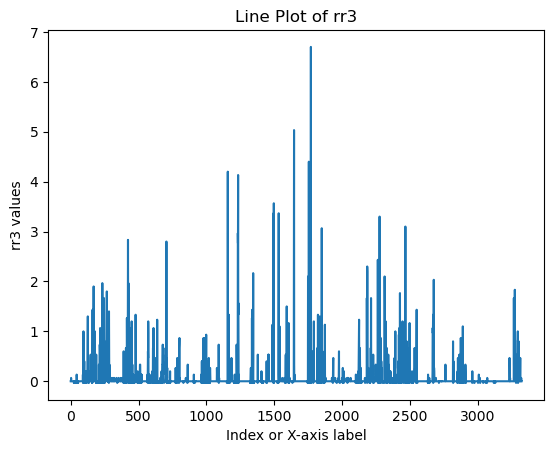

In [6]:
import matplotlib.pyplot as plt

# Assuming 'rain' is your DataFrame and 'rr3' is the column you want to plot
plt.plot(rain['rr3'])

# Adding labels and title
plt.xlabel('Index or X-axis label')
plt.ylabel('rr3 values')
plt.title('Line Plot of rr3')

# Display the plot
plt.show()


In [7]:
merged_df = pd.merge(data, rain, on='date', how='left')
merged_df['rr3']=merged_df['rr3'].interpolate(method = 'bfill')
data=merged_df
#data.nunique()
data

,counter_name,site_name,date,log_bike_count,hour,rr3
0,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 02:00:00,0.000000,2,0.0
1,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 03:00:00,0.693147,3,0.0
2,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 04:00:00,0.000000,4,0.0
3,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 15:00:00,1.609438,15,0.0
4,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 18:00:00,2.302585,18,0.0
...,...,...,...,...,...,...
496822,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 06:00:00,6.100319,6,0.0
496823,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 10:00:00,4.983607,10,0.0
496824,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 15:00:00,5.389072,15,0.0
496825,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 22:00:00,3.091042,22,NaN


## Trucs du prof


In [8]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [9]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
sample_encoded = date_encoder.fit_transform(data[["date"]]).head()
sample_encoded

,year,month,day,weekday,hour
0,2020,9,1,1,2
1,2020,9,1,1,3
2,2020,9,1,1,4
3,2020,9,1,1,15
4,2020,9,1,1,18


In [10]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

enc = OneHotEncoder(sparse_output=False)

enc.fit_transform(sample_encoded[["hour"]])

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

## Weekend

In [11]:
data["is_weekend"]=data["date"].dt.dayofweek.isin([5, 6])
data

,counter_name,site_name,date,log_bike_count,hour,rr3,is_weekend
0,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 02:00:00,0.000000,2,0.0,False
1,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 03:00:00,0.693147,3,0.0,False
2,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 04:00:00,0.000000,4,0.0,False
3,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 15:00:00,1.609438,15,0.0,False
4,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 18:00:00,2.302585,18,0.0,False
...,...,...,...,...,...,...,...
496822,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 06:00:00,6.100319,6,0.0,False
496823,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 10:00:00,4.983607,10,0.0,False
496824,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 15:00:00,5.389072,15,0.0,False
496825,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 22:00:00,3.091042,22,NaN,False


## Holidays

In [12]:
import holidays
holidays = holidays.CountryHoliday('France')

# Function to check if a date is a holiday
def is_holiday(date):
    return 1 if date in holidays else 0

# Add a "Holiday" column to the DataFrame
data['Holiday'] = data['date'].apply(is_holiday)
data


,counter_name,site_name,date,log_bike_count,hour,rr3,is_weekend,Holiday
0,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 02:00:00,0.000000,2,0.0,False,0
1,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 03:00:00,0.693147,3,0.0,False,0
2,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 04:00:00,0.000000,4,0.0,False,0
3,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 15:00:00,1.609438,15,0.0,False,0
4,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 18:00:00,2.302585,18,0.0,False,0
...,...,...,...,...,...,...,...,...
496822,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 06:00:00,6.100319,6,0.0,False,0
496823,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 10:00:00,4.983607,10,0.0,False,0
496824,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 15:00:00,5.389072,15,0.0,False,0
496825,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 22:00:00,3.091042,22,NaN,False,0


## Season

In [13]:
from datetime import datetime
def get_season(date):
    if (date.month >= 1 and date.month < 3) or (date.month == 12 and date.day >= 21):
        return 1  # Winter
    elif date.month >= 3 and date.month < 6:
        return 2  # Spring
    elif date.month >= 6 and date.month < 9:
        return 3  # Summer
    elif date.month >= 9 and date.month < 12:
        return 4  # Autumn

In [14]:
data['Season'] = data['date'].apply(get_season)
data

,counter_name,site_name,date,log_bike_count,hour,rr3,is_weekend,Holiday,Season
0,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 02:00:00,0.000000,2,0.0,False,0,4.0
1,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 03:00:00,0.693147,3,0.0,False,0,4.0
2,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 04:00:00,0.000000,4,0.0,False,0,4.0
3,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 15:00:00,1.609438,15,0.0,False,0,4.0
4,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 18:00:00,2.302585,18,0.0,False,0,4.0
...,...,...,...,...,...,...,...,...,...
496822,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 06:00:00,6.100319,6,0.0,False,0,4.0
496823,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 10:00:00,4.983607,10,0.0,False,0,4.0
496824,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 15:00:00,5.389072,15,0.0,False,0,4.0
496825,254 rue de Vaugirard SO-NE,254 rue de Vaugirard,2021-09-09 22:00:00,3.091042,22,NaN,False,0,4.0


## Couvre-feux


In [46]:

def encode_couvre_feu(row):
    hour = row['date'].hour

    if (
        (pd.to_datetime('2020-10-17') < row['date'] < pd.to_datetime('2020-10-29')) or
        (pd.to_datetime('2021-05-19') < row['date'] < pd.to_datetime('2021-06-08'))
    ):
        return 1 if 23 <= hour < 6 else 0  # Couvre-feu 23h-6h
    elif (
        (pd.to_datetime('2020-12-15') < row['date'] < pd.to_datetime('2021-01-15'))
    ):
        return 1 if 20 <= hour < 6 else 0  # Couvre-feu 20h-6h
    elif (
        (pd.to_datetime('2020-01-16') < row['date'] < pd.to_datetime('2021-03-19'))
    ):
        return 1 if 18 <= hour < 6 else 0  # Couvre-feu 18h-6h
    elif (
        (pd.to_datetime('2020-03-20') < row['date'] < pd.to_datetime('2021-05-18'))
    ):
        return 1 if 19 <= hour < 6 else 0  # Couvre-feu 19h-6h
    elif (
        (pd.to_datetime('2021-06-09') < row['date'] < pd.to_datetime('2021-06-20'))
    ):
        return 1 if 23 <= hour < 6 else 0  # Couvre-feu 23h-6h
    else:
        return 0  # Pas de couvre-feu



# Linear model

In [48]:
import utils

X, y = utils.get_train_data()
X.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233


In [49]:
#data2 = pd.read_csv(Path("data") / 'external_data.csv')
#data2['date']=pd.to_datetime(data2['date'])
#data2 = data2.drop_duplicates()
#Rain feature
#rain = data2[['date','rr3']]
#rain['rr3']= rain['rr3']*(1/3)
#Weekend feature
X['date'] = pd.to_datetime(X['date'])

X=X.drop(
    columns=[
        "site_id",
        "counter_id",
        "coordinates",
        "counter_technical_id",
        "counter_installation_date",
        "latitude",
        "longitude"
    ]
)
X["is_weekend"]=X["date"].dt.dayofweek.isin([5, 6])
X['is_holiday'] = X['date'].apply(is_holiday)
X['season'] = X['date'].apply(get_season)
X['is_confinement'] = (X["date"] > '2020-03-17') & (X["date"] < '2020-05-11') | (X["date"] > '2020-10-30') & (X["date"] < '2020-12-15')| (X["date"] > '2021-04-03') & (X["date"] < '2021-05-03')
X["is_couvre_feu"] = X.apply(encode_couvre_feu, axis=1)

#X["couvre-feu 21h-6h"] = (X["date"]> '2020-10-17')& (X["date"] < '2020-10-29')| (X["date"] > '2021-05-19') & (X["date"] < '2021-06-08')
#X["couvre-feu 20h-6h"] = (X["date"]> '2020-12-15')& (X["date"] < '2021-01-15')
#X["couvre-feu 18h-6h"] = (X["date"]> '2020-01-16')& (X["date"] < '2021-03-19')
#X["couvre-feu 19h-6h"] = (X["date"]> '2020-03-20')& (X["date"] < '2021-05-18')
#X["couvre-feu 23h-6h"]= (X["date"] > '2021-06-09') & (X["date"] < '2021-06-20')

pd.merge(x,y,on'date', how = 'left')

In [50]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [51]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x13aadbf60>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

In [53]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.73


In [54]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


In [55]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

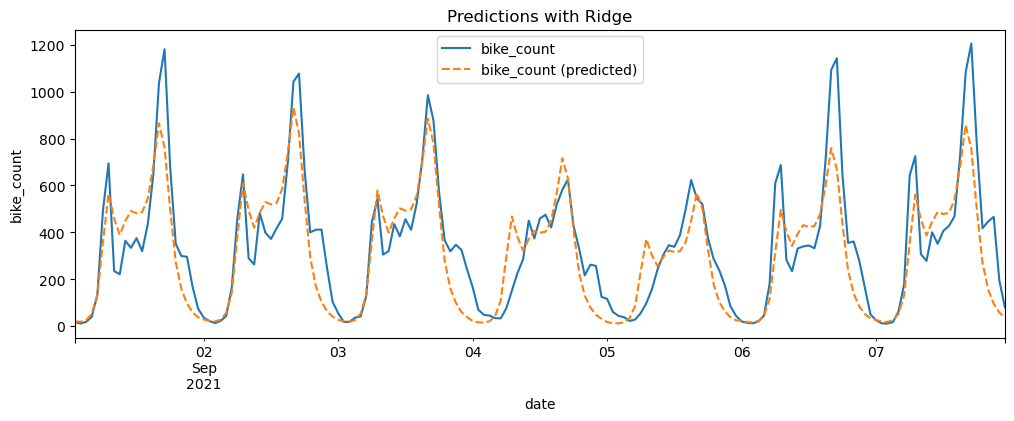

In [56]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

<Axes: xlabel='y_true', ylabel='y_pred'>

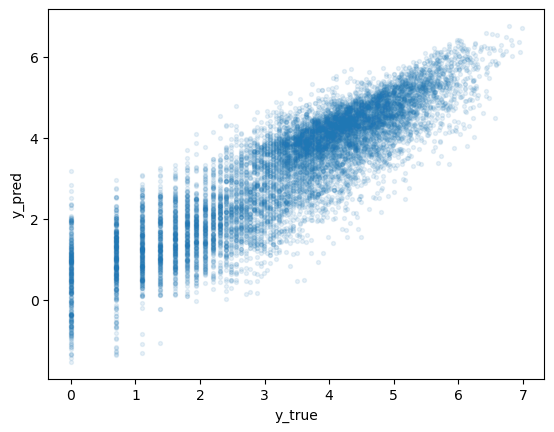

In [57]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

In [58]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.96370993 -0.87155645 -0.85104537 -0.87402957 -1.06387423 -0.96757061]
RMSE (all folds): 0.932 ± 0.0744


# XGBRegressor

In [59]:
def identity(x):
    return x

In [60]:
from xgboost import XGBRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

binary_cols = ["is_weekend","is_holiday","season","is_confinement","is_couvre_feu"]
binary_encoder = FunctionTransformer(func=identity, validate=False)

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]
#categorical_encoder_2 = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value= np.nan, max_categories = 4)
#categorical_cols_2 = ["temperature"]
#standard_scaler = StandardScaler()
#poly_fit = PolynomialFeatures(degree=3)
#continuous_var = ["tn12"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("bin", binary_encoder, binary_cols)
        #("cat2", categorical_encoder_2, categorical_cols_2)
        #"continuous", poly_fit, continuous_var)
    ]
)

regressor = XGBRegressor(random_state = 42)
#regressor.fit(X_train, y_train, categorical_feature=categorical_cols)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x13aadbf60>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('bin',
                                                  FunctionTransformer(fun...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [61]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.82367648 -0.90270337 -0.71748825 -0.78376142 -0.89935697 -0.74921484]
RMSE (all folds): 0.813 ± 0.0703


In [62]:
print(pipe.get_params)

<bound method Pipeline.get_params of Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x13aadbf60>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('bin',
                                                  FunctionTransformer(fun...
                              feature_types=None, gamma=None, grow_policy=None,
           

In [63]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'xgbregressor__n_estimators': [100, 200, 300],
    'xgbregressor__max_depth': [6, 9, 12],
    'xgbregressor__learning_rate': [0.1, 0.5, 0.05],
}

custom_cv = utils.get_cv(X_train, y_train, random_state=0)

grid_search = GridSearchCV(
    pipe,  # Your pipeline
    param_grid=param_grid,  # The parameter grid
    cv=custom_cv,  # Your cross-validator
    scoring="neg_root_mean_squared_error",  # The scoring metric
    n_jobs=-1  # Use all available CPUs for parallel processing
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=<generator object get_cv at 0x16b769ea0>,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _encode_dates at 0x13aadbf60>)),
                                       ('columntransformer',
                                        ColumnTransformer(transformers=[('date',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['year',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                                          'hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__learning_rate': [0.1, 0.5, 0.05],
                         'xgbregressor__max_depth': [6, 9, 12],
                         'xgbregressor__n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [65]:
print("Best Parameters: ", grid_search.best_params_)
print("Best RMSE: ", -grid_search.best_score_)

Best Parameters:  {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 9, 'xgbregressor__n_estimators': 300}
Best RMSE:  0.7610623913109146


# SGDRegressor

In [ ]:
from sklearn.linear_model import SGDRegressor
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = SGDRegressor(random_state = 42)
#regressor.fit(X_train, y_train, categorical_feature=categorical_cols)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x289ebbb00>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('sgdregressor', SGDRegressor(random_state=42))])

In [ ]:
cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.85406942 -1.74773686 -1.29495917 -1.02859285 -1.16088474 -1.08124006]
RMSE (all folds): 1.19 ± 0.281


In [ ]:
pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x289ebbb00>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('sgdregressor', SGDRegressor(random_state=42))])>

In [ ]:
param_grid = {
    'sgdregressor__penalty':['l1','l2','elasticnet'],
    'sgdregressor__learning_rate':['constant','optimal','invscaling','adaptive'],
    'sgdregressor__loss':['squared_error', 'epsilon_insensitive', 'huber', 'squared_epsilon_insensitive']
}

custom_cv = utils.get_cv(X_train, y_train, random_state=0)

grid_search = GridSearchCV(
    pipe,  # Your pipeline
    param_grid=param_grid,  # The parameter grid
    cv=custom_cv,  # Your cross-validator
    scoring="neg_root_mean_squared_error",  # The scoring metric
    n_jobs=-1  # Use all available CPUs for parallel processing
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=<generator object get_cv at 0x174adef80>,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _encode_dates at 0x289ebbb00>)),
                                       ('columntransformer',
                                        ColumnTransformer(transformers=[('date',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['year',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                                          'hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore...
                                                                          'site_name'])])),
                                       ('sgdregressor',
                                        SGDRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'sgdregressor__learning_rate': ['constant', 'optimal',
                                                         'invscaling',
                                                         'adaptive'],
                         'sgdregressor__loss': ['squared_error',
                                                'epsilon_insensitive', 'huber',
                                                'squared_epsilon_insensitive'],
                         'sgdregressor__penalty': ['l1', 'l2', 'elasticnet']},
             scoring='neg_root_mean_squared_error')

In [ ]:
print("Best Parameters: ", grid_search.best_params_)
print("Best RMSE: ", -grid_search.best_score_)

Best Parameters:  {'sgdregressor__learning_rate': 'optimal', 'sgdregressor__loss': 'huber', 'sgdregressor__penalty': 'l2'}
Best RMSE:  1.0927280564573747


# CatBoostRegressor

In [ ]:
from catboost import CatBoostRegressor
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = CatBoostRegressor(random_state = 42)
#regressor.fit(X_train, y_train, categorical_feature=categorical_cols)

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Learning rate set to 0.107739
0:	learn: 1.5993758	total: 30.2ms	remaining: 30.2s
1:	learn: 1.5362886	total: 42.7ms	remaining: 21.3s
2:	learn: 1.4831454	total: 55.2ms	remaining: 18.3s
3:	learn: 1.4382211	total: 68.6ms	remaining: 17.1s
4:	learn: 1.3989890	total: 79.8ms	remaining: 15.9s
5:	learn: 1.3669583	total: 92.3ms	remaining: 15.3s
6:	learn: 1.3404826	total: 104ms	remaining: 14.8s
7:	learn: 1.3097723	total: 113ms	remaining: 14s
8:	learn: 1.2882054	total: 123ms	remaining: 13.5s
9:	learn: 1.2631862	total: 133ms	remaining: 13.1s
10:	learn: 1.2409026	total: 142ms	remaining: 12.8s
11:	learn: 1.2227413	total: 152ms	remaining: 12.5s
12:	learn: 1.2055092	total: 161ms	remaining: 12.2s
13:	learn: 1.1886651	total: 172ms	remaining: 12.1s
14:	learn: 1.1730104	total: 182ms	remaining: 11.9s
15:	learn: 1.1589581	total: 191ms	remaining: 11.7s
16:	learn: 1.1442665	total: 202ms	remaining: 11.7s
17:	learn: 1.1321493	total: 211ms	remaining: 11.5s
18:	learn: 1.1207598	total: 220ms	remaining: 11.4s
19:	lea

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x157ac11c0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x29acdab90>)])

In [ ]:
cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

Learning rate set to 0.079223
0:	learn: 1.5434400	total: 4.11ms	remaining: 4.1s
1:	learn: 1.4910381	total: 7.46ms	remaining: 3.72s
2:	learn: 1.4445436	total: 9.73ms	remaining: 3.23s
3:	learn: 1.4016765	total: 11.6ms	remaining: 2.88s
4:	learn: 1.3650268	total: 13.7ms	remaining: 2.73s
5:	learn: 1.3310438	total: 15.8ms	remaining: 2.61s
6:	learn: 1.3018953	total: 17.9ms	remaining: 2.54s
7:	learn: 1.2749223	total: 20.1ms	remaining: 2.49s
8:	learn: 1.2515476	total: 22.4ms	remaining: 2.47s
9:	learn: 1.2305276	total: 24.6ms	remaining: 2.44s
10:	learn: 1.2060544	total: 26.8ms	remaining: 2.4s
11:	learn: 1.1881042	total: 29.5ms	remaining: 2.42s
12:	learn: 1.1662608	total: 31.7ms	remaining: 2.4s
13:	learn: 1.1495711	total: 33.9ms	remaining: 2.39s
14:	learn: 1.1339110	total: 36.2ms	remaining: 2.37s
15:	learn: 1.1163740	total: 38.3ms	remaining: 2.35s
16:	learn: 1.1018209	total: 40.6ms	remaining: 2.35s
17:	learn: 1.0872972	total: 42.6ms	remaining: 2.32s
18:	learn: 1.0744919	total: 44.8ms	remaining: 2

In [ ]:
pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x157ac11c0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x29acdab90>)])>

In [ ]:
param_grid = {
    'catboostregressor__iterations': [50, 100, 200],
    'catboostregressor__depth': [3, 6, 9],
    'catboostregressor__learning_rate': [0.1, 0.5, 0.05],
}

custom_cv = utils.get_cv(X_train, y_train, random_state=0)

grid_search = GridSearchCV(
    pipe,  # Your pipeline
    param_grid=param_grid,  # The parameter grid
    cv=custom_cv,  # Your cross-validator
    scoring="neg_root_mean_squared_error",  # The scoring metric
    n_jobs=-1  # Use all available CPUs for parallel processing
)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

0:	learn: 1.5270507	total: 71.5ms	remaining: 3.5s
1:	learn: 1.4901423	total: 77ms	remaining: 1.85s
2:	learn: 1.4579650	total: 83.9ms	remaining: 1.31s
3:	learn: 1.4303306	total: 94.8ms	remaining: 1.09s
4:	learn: 1.4051378	total: 101ms	remaining: 905ms
5:	learn: 1.3809198	total: 105ms	remaining: 773ms
6:	learn: 1.3590244	total: 109ms	remaining: 670ms
7:	learn: 1.3377535	total: 112ms	remaining: 585ms
8:	learn: 1.3196766	total: 118ms	remaining: 536ms
9:	learn: 1.3027173	total: 125ms	remaining: 500ms
10:	learn: 1.2841176	total: 132ms	remaining: 467ms
11:	learn: 1.2661700	total: 151ms	remaining: 480ms
12:	learn: 1.2511138	total: 172ms	remaining: 490ms
13:	learn: 1.2346249	total: 180ms	remaining: 463ms
14:	learn: 1.2200460	total: 183ms	remaining: 427ms
15:	learn: 1.2056543	total: 202ms	remaining: 430ms
16:	learn: 1.1926472	total: 206ms	remaining: 401ms
17:	learn: 1.1795929	total: 209ms	remaining: 372ms
18:	learn: 1.1689030	total: 212ms	remaining: 345ms
19:	learn: 1.1566906	total: 216ms	remain

GridSearchCV(cv=<generator object get_cv at 0x157a3ac20>,
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function _encode_dates at 0x157ac11c0>)),
                                       ('columntransformer',
                                        ColumnTransformer(transformers=[('date',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['year',
                                                                          'month',
                                                                          'day',
                                                                          'weekday',
                                                                          'hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['counter_name',
                                                                          'site_name'])])),
                                       ('catboostregressor',
                                        <catboost.core.CatBoostRegressor object at 0x29acdab90>)]),
             n_jobs=-1,
             param_grid={'catboostregressor__depth': [3, 6, 9],
                         'catboostregressor__iterations': [50, 100, 200],
                         'catboostregressor__learning_rate': [0.1, 0.5, 0.05]},
             scoring='neg_root_mean_squared_error')

In [ ]:
print("Best Parameters: ", grid_search.best_params_)
print("Best RMSE: ", -grid_search.best_score_)

Best Parameters:  {'catboostregressor__depth': 6, 'catboostregressor__iterations': 200, 'catboostregressor__learning_rate': 0.5}
Best RMSE:  0.7996896191358607
